# **<span style="color:#e76f51;">TPS: Feb 2022: Bacterial Species Classification</span>**

- Multi-class classification problem
- Features: 10-mer snippets of DNA that are sampled and analyzed to give the histogram of base count.
- What do all the numbers in the features represent? Well, plot below might help a little bit....

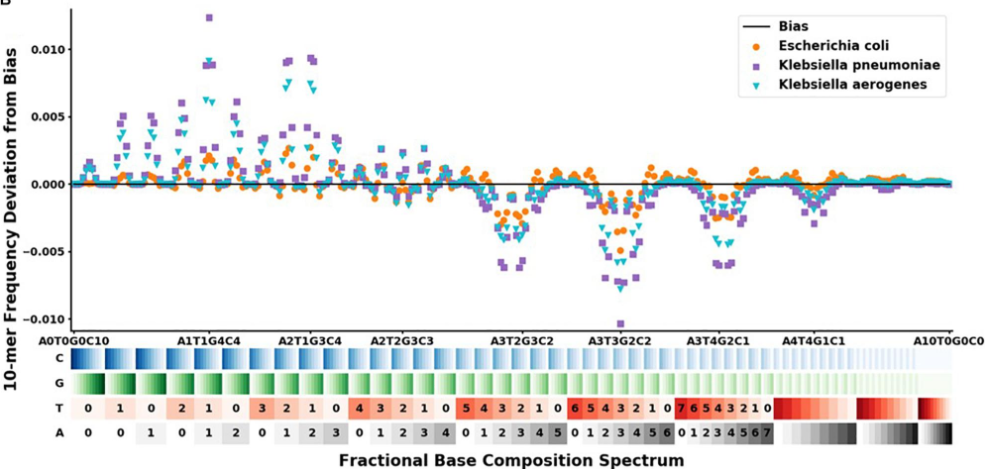

Image source: https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full

- **Import required python packages**

In [ ]:
# libraries
import random
import os, math
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

from collections import Counter, defaultdict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

import optuna
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# Finding the weighting coefficients for each of the fold-models

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

## **<span style="color:#e76f51;">Data</span>**
- > train.csv: row_id, target, and 286 features,
- > test.csv: row_id, and 286 features,

In [ ]:
df_train = pd.read_csv("/kaggle/input/tabular-playground-series-feb-2022/train.csv")
df_test = pd.read_csv("/kaggle/input/tabular-playground-series-feb-2022/test.csv")

In [ ]:
print("train.csv shape: ", df_train.shape)
print("test.csv shape: ", df_test.shape)

In [ ]:
# Multi-class distribution in the train dataset
sns.countplot(x="target", data=df_train);
plt.xticks(rotation=90);

- ***Great!,*** no class imbalance in the train dataset.

In [ ]:
for f in df_train.columns:
    missing_cnt = df_train[f].isnull().sum()
    if missing_cnt > 0:
        print(f, missing_cnt/df_train.shape[0])

- ***Okay***,  no missing values either.

In [ ]:
df_train.head()

In [ ]:
# Any categorical features?
for col in df_train.columns:
    if df_train[col].dtype == "object":
        print(col)

### **<span style="color:#e76f51;">LabelEncoder</span>**
> Encoding target class (bacterial species name) into integers

In [ ]:
encoder = LabelEncoder()
df_train.target = encoder.fit_transform(df_train.target.values)

In [ ]:
# Encoded target label map
print("="*30)
print("TARGET LABEL ENCODING MAP")
print("="*30)
for code in range(10):
    bacteria_sp = encoder.inverse_transform([code])[0]
    print(code, "==>",  bacteria_sp)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
for f in tqdm(df_train.columns):
    if f != "row_id" or f != "target":
        corr, p = pearsonr(df_train.target.values, df_train[f].values)
        if abs(corr) > 0.07:
            print(f, ": ", round(corr, 3), ",  p=", round(p, 3))

### Training and Testing Data

In [ ]:
# train data
y = df_train.target
X = df_train.drop(columns=["row_id", "target"])

# test data
X_test = df_test.drop(columns=["row_id"])
test_row_ids = df_test.row_id.values

### **<span style="color:#e76f51;">Dimensionality Reduction</span>**

- Reducing the dimension, using UMAP, and plotting on lower dimension.
- 2D and 3D dimensionality reductions

In [ ]:
from umap import UMAP
import umap.plot

In [ ]:
mapper = UMAP(n_neighbors=25, n_components=2, metric="minkowski").fit(X[:10000])
umap.plot.points(mapper, labels=y[:10000], theme='fire');

In [ ]:
# 3D plot
_umap = UMAP(n_neighbors=25, n_components=3, metric="minkowski", init='random', random_state=22)
x_umap = _umap.fit_transform(X[:10000])
umap_df = pd.DataFrame(x_umap)
y_sr = pd.Series(y[:10000], name='label')
tmp = pd.concat([umap_df, y_sr], axis=1)
fig = px.scatter_3d(tmp, x=0, y=1, z=2, color='label', labels={'color': 'number'})
fig.update_traces(marker_size=1)
fig.show();

In [ ]:
# Data preparation for model training and prediction
# We will reduce X to lower dimension (try: 25) and use the data for training

# um = UMAP(n_neighbors=25, n_components=15, metric="minkowski", random_state=22)
# X_red = um.fit_transform(X)
# X_test_red = um.transform(X_test)

## **<span style="color:#e76f51;">Model & Training</span>**

- 5-fold Stratified Cross-Validation training, and oof prediction on test data.

In [ ]:
# Evaluation Metric: Categorical accuracy
# custom evaluation metric: for LGB model
n_class = 10
def accuracy_lgb(y_true, y_hat):
    y_hat = np.array(y_hat).reshape(len(y_true), n_class)
    y_hat = np.argmax(y_hat, axis=1)
    return 'ACCURACY', metrics.accuracy_score(y_true, y_hat), True

In [ ]:
NFOLDS = 5
n_class = 10
st_kfolds = StratifiedKFold(n_splits=NFOLDS, shuffle=True)

lgb_params = {
                "objective": "multiclass",
                "boosting_type": "dart",
                "n_estimators": 2400,
                "is_unbalance": "false",
                "max_depth": 6,
                "num_leaves": 55,
                "reg_alpha": 5.0,
                "reg_lambda": 10.0,
                "learning_rate": 0.1, 
                "metric": ["multi_logloss"],
                #"device": "gpu",
                "verbose": -1
            }


# f_labels = [f"feature_{i}" for i in range(15)]
# X_red = pd.DataFrame(data=X_red, columns=f_labels)

predictions = np.zeros((X_test.shape[0], n_class))
mean_acc_score = 0
for fold, (tr_idx, val_idx) in enumerate(st_kfolds.split(X, y)):
    if fold > 0:
        print("="*65)
    print("FOLD: ", fold)
    
    X_train, y_train = X.iloc[tr_idx], y.iloc[tr_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    
    print("Train size: ", X_train.shape[0])
    print("Validation size: ", X_valid.shape[0])
    
    # Model with parameters
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        #eval_metric=accuracy_lgb,
        early_stopping_rounds=100,
        verbose=100
    )

    # validation data:
    valid_proba = model.predict_proba(X_valid)
    valid_pred = np.argmax(valid_proba, axis=1)
    acc_score = metrics.accuracy_score(y_valid, valid_pred)
    print("Validation ACC: ", acc_score)
    mean_acc_score += acc_score/NFOLDS
    
    predictions += model.predict_proba(X_test)/NFOLDS

In [ ]:
print("Mean CV accuracy: ", mean_acc_score)

## **<span style="color:#e76f51;">Prediction & Submission </span>**

In [ ]:
# encoding back to original target class label names
edcoded_res = np.argmax(predictions, axis=1)
pred_results = encoder.inverse_transform(edcoded_res)

In [ ]:
# test results submission
ans = pd.DataFrame(data={"row_id": test_row_ids, "target": pred_results})
ans.to_csv("submission.csv", index=False)

In [ ]:
ans.head()

**Thanks for reading!**